In [1]:
import torch
from torch import nn
from torchinfo import summary

from IPython.display import display as d

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt

from einops import rearrange

import lightning as L

In [2]:
from src.data.components.dataset import CreditsHistoryDataset
from src.data.components.targets_indexes_reader import TargetsReader, IndexesReader
from src.data.components.data_reader import DataReader
from src.utils.sampler import SamplerFactory
from src.utils.metrics import GINI
from torchmetrics import MeanMetric

# Multitask research

In [3]:
emb_dim = 128

In [44]:
sample = torch.randint(0, 4, (5, ))

In [45]:
d(sample)

tensor([2, 0, 1, 3, 3])

In [46]:
a = nn.Embedding(num_embeddings=4, embedding_dim=8)

In [47]:
d(dict(a.named_parameters()))

{'weight': Parameter containing:
 tensor([[ 1.2962,  0.5405,  0.5765, -0.8487,  0.2105,  0.0374, -1.7631, -1.2126],
         [ 0.2306, -0.5026, -1.0136, -0.8195, -0.7585,  0.4862,  0.5229,  0.2072],
         [-0.2808, -0.1399,  0.6364,  0.4589,  0.8277,  1.0517, -0.7562,  1.4967],
         [ 0.4944, -0.2382,  0.6527, -0.6246, -0.8596, -1.7815,  0.0119,  1.2357]],
        requires_grad=True)}

In [49]:
d(a(sample))

tensor([[-0.2808, -0.1399,  0.6364,  0.4589,  0.8277,  1.0517, -0.7562,  1.4967],
        [ 1.2962,  0.5405,  0.5765, -0.8487,  0.2105,  0.0374, -1.7631, -1.2126],
        [ 0.2306, -0.5026, -1.0136, -0.8195, -0.7585,  0.4862,  0.5229,  0.2072],
        [ 0.4944, -0.2382,  0.6527, -0.6246, -0.8596, -1.7815,  0.0119,  1.2357],
        [ 0.4944, -0.2382,  0.6527, -0.6246, -0.8596, -1.7815,  0.0119,  1.2357]],
       grad_fn=<EmbeddingBackward0>)

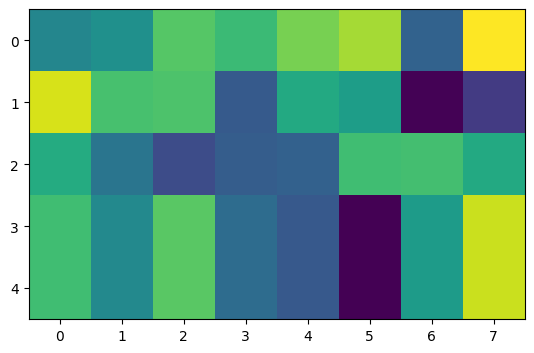

In [48]:
plt.imshow(a(sample).detach())

In [153]:
d(torch.concatenate([torch.stack(item).T for item in a]).unbind(dim=1))

(tensor([1, 2, 3, 1, 2, 3]), tensor([2, 3, 4, 2, 3, 4]))

In [6]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, dropout=0.1):
        super().__init__()

        self.position_wise_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

        self.layer_norm = nn.LayerNorm(input_size, eps=1e-6)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.position_wise_layer(x)
        x = self.dropout(x)
        
        x += residual

        x = self.layer_norm(x)

        return x

In [31]:
class FooModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, max_seq_len: int = 50, dropout=0.1):
        super().__init__()

        self.position_wise_forward = PositionwiseFeedForward(
            input_size=emb_dim, 
            hidden_size=emb_dim * 2, 
            dropout=dropout
        )

        self.linear_layer = nn.Linear(emb_dim, 1)

        self.avg_pool = nn.AvgPool1d(kernel_size=max_seq_len)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.position_wise_forward(inputs)

        x = self.linear_layer(x).squeeze()

        x = self.avg_pool(x)

        return x

In [7]:
some_batch = (torch.randn(size=(32, 50, emb_dim)), torch.randint(0, 2, (32, ), dtype=torch.float32))

In [32]:
some_model = FooModel(emb_dim, emb_dim * 2, 50)

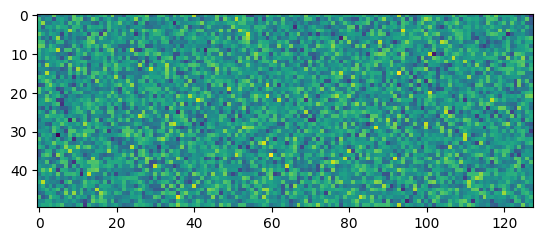

In [18]:
plt.imshow(some_batch[0][0])

In [33]:
d(some_model(some_batch[0]).size())

torch.Size([32, 1])

In [34]:
from torchmetrics.classification.auroc import BinaryAUROC

In [70]:
class GINI(BinaryAUROC):
    def __init__(self) -> None:
        super(GINI, self).__init__()
        
    def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        return (2. * super().forward(logits, labels) - 1.) * 100.
    
    # def compute(self) -> torch.Tensor:
    #     return super().compute()

In [71]:
a = GINI()

In [72]:
d(a(some_model(some_batch[0]), some_batch[1]))

tensor(43.7500)

In [119]:
d(some_model(some_batch[0]))

tensor([ 0.0903,  0.0469,  0.0347, -0.1100,  0.0162,  0.0895,  0.0320,  0.1441,
         0.0787,  0.0022,  0.0888, -0.0043,  0.1492, -0.0996,  0.0271,  0.0832,
        -0.0649,  0.0250,  0.0833, -0.0095,  0.1098,  0.1297,  0.0403,  0.0176,
        -0.0573, -0.0441, -0.1633,  0.0786, -0.0913,  0.0039, -0.0435, -0.0718],
       grad_fn=<MeanBackward1>)

In [86]:
d(a._buffers)

OrderedDict()

In [120]:
d((0.5749 * 2 - 1) * 100)

14.979999999999993

In [73]:
d(a.compute())

tensor(0.7188)

In [31]:
d(some_model.training_step(some_batch))

tensor(0.6924)
tensor(11.7409)
tensor(0.5587) 



/home/danil/projects/torch_template/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


{'loss': tensor(0.6924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)}

# Dataset

In [3]:
from src.data.components.collate import ModelInput, SingleForwardState, BaseCollator, ModelOutput

In [4]:
def set_sampler(targets: dict, n_samples: int = 1000, replacement: bool = True):

    targets = np.asarray(list(targets.values()))
    
    sampler_factory = SamplerFactory(
        targets=targets, 
        n_samples=n_samples,
        replacement=replacement
    )
    return sampler_factory.balanced_random_sampler()

In [5]:
def initialize_data(features_path: str, data_path: str, indexes_path: str, targets_path: str, use_sampler: bool = True, batch_size: int = 32):
    features_dict = OmegaConf.load(features_path)

    data_reader = DataReader(data_path=data_path)
    data_reader.setup()

    indexes = IndexesReader(train_path=indexes_path).train_indexes

    targets = TargetsReader(targets_path).targets

    targets = {idx: targets.get(idx) for idx in indexes}

    dataset = CreditsHistoryDataset(
        data=data_reader, 
        targets=targets,
        indexes=indexes,
        features=features_dict
    )

    print(f"dataset sample: {dataset[0]}")

    train_sampler = set_sampler(
        targets=dataset.targets, 
        n_samples=10000,
        replacement=False
    ) if use_sampler else None

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=BaseCollator(max_seq_len=50),
        sampler=train_sampler,
        drop_last=True
    ) 

    return dataloader, features_dict

In [6]:
test_dataloader, _ = initialize_data(
    "configs/data/features/features_credits_aggregated_v2.yaml",
    "./data/credits-history/serialized/serialized_first_part_v2",
    "./data/credits-history/indexes/ser_full_0_indexes/train_indexes.pickle",
    "./data/credits-history/targets/targets_dict.pickle",
    use_sampler=False,
    batch_size=1024
)

dataset sample: {'numerical': tensor([[ 1.9200,  1.0005,  0.8417,  0.5399,  7.2181,  0.0000],
        [ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.5200,  1.6636,  0.9957, -0.0927,  7.2181,  0.0000],
        [ 0.4800,  0.1688,  0.1680,  0.9858,  7.2181,  0.0000],
        [ 3.1200,  2.6531,  0.4693, -0.8830,  7.2181,  0.0000],
        [ 0.2400,  0.0925,  0.0923,  0.9957,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 1.2000,  0.4866,  0.4677,  0.8839,  7.2181,  0.0000],
        [ 2.2800,  1.3662,  0.9791,  0.2032,  7.2181,  0.0000],
        [ 2.6400,  1.8312,  0.9663, -0.2574,  7.2181,  0.0000]]), 'categorical': tensor([[ 8, 12,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4, 11,
          0],
        [ 8,  6,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4,  0,
         

In [7]:
dataloader, features_dict = initialize_data(
    "configs/data/features/features_credits_aggregated_v2.yaml",
    "./data/credits-history/serialized/serialized_first_part_v2",
    "./data/credits-history/indexes/ser_full_0_indexes/train_indexes.pickle",
    "./data/credits-history/targets/targets_dict.pickle"
)

dataset sample: {'numerical': tensor([[ 1.9200,  1.0005,  0.8417,  0.5399,  7.2181,  0.0000],
        [ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.5200,  1.6636,  0.9957, -0.0927,  7.2181,  0.0000],
        [ 0.4800,  0.1688,  0.1680,  0.9858,  7.2181,  0.0000],
        [ 3.1200,  2.6531,  0.4693, -0.8830,  7.2181,  0.0000],
        [ 0.2400,  0.0925,  0.0923,  0.9957,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 1.2000,  0.4866,  0.4677,  0.8839,  7.2181,  0.0000],
        [ 2.2800,  1.3662,  0.9791,  0.2032,  7.2181,  0.0000],
        [ 2.6400,  1.8312,  0.9663, -0.2574,  7.2181,  0.0000]]), 'categorical': tensor([[ 8, 12,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4, 11,
          0],
        [ 8,  6,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4,  0,
         

In [8]:
d(next(iter(dataloader)))

ModelBatch(numerical=tensor([[[ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
         [ 1.6800,  0.8012,  0.7182,  0.6959,  7.2181,  0.0000],
         [ 0.1200,  0.0587,  0.0586,  0.9983,  7.2181,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.3200,  1.4793,  0.9958,  0.0914,  7.2181,  0.2000],
         [ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
         [ 2.5200,  1.6636,  0.9957, -0.0927,  7.2181,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.8800,  2.2093,  0.8030, -0.5960,  7.2181,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, 

# Model

## Get sample check 

In [9]:
def get_sample():
    batch = next(iter(dataloader))

    x = ModelInput(
        numerical=batch.numerical,
        categorical=batch.categorical,
        mask=batch.mask
    )

    labels = batch.targets

    return x, labels

In [10]:
sample = get_sample()

In [11]:
d(sample[0].numerical.size())

torch.Size([32, 50, 6])

In [25]:
d((~sample[0].mask).sum(dim=1).size())

torch.Size([32])

In [12]:
d(rearrange(sample[0].numerical, "N L H -> N H L"))

tensor([[[ 1.6800,  2.0000,  2.4800,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8012,  1.1430,  1.6569,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7182,  0.9099,  0.9963,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.6959,  0.4149, -0.0860,  ...,  0.0000,  0.0000,  0.0000],
         [ 7.2181,  7.2181,  7.2181,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.2500,  0.4500,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.6800,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8012,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7182,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.6959,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 7.2181,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1200,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0587,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
  

## Model layers check

In [11]:
class EmbeddingLayer(nn.Module):
    def __init__(
            self,
            categorical_features: dict,
            embedding_dim: int = 32,
            div_emb_dim: int = 4
        ) -> None:
        super(EmbeddingLayer, self).__init__()

        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleList()

        for num_embs in self.categorical_features.values():
            embedding = nn.Embedding(
                num_embeddings=num_embs, 
                embedding_dim=embedding_dim // div_emb_dim
            )

            nn.init.xavier_normal_(embedding.weight, gain=nn.init.calculate_gain('relu'))

            self.embeddings.append(embedding)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = torch.concatenate(
            [embedding(x[..., idx]) for idx, embedding in enumerate(self.embeddings)], dim=-1
        ) # size = (batch_size, len(cat_features), embedding_dim)
        
        return x

    
class EncoderLayer(nn.Module):
    def __init__(
            self,
            numerical_features: list,
            categorical_features: dict,
            embedding_dim: int = 16,
            dropout_inputs: float = 0.5,
            non_linear: bool = False,
            num_batch_norm: bool = True,
            div_emb_dim: int = 4
        ) -> None:
        super(EncoderLayer, self).__init__()

        self.dropout = nn.Dropout(p=dropout_inputs)

        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

        self.embeddings = EmbeddingLayer(
            categorical_features=categorical_features,
            embedding_dim=embedding_dim,
            div_emb_dim=div_emb_dim
        )

        if non_linear:
            self.out_linear_block = nn.Sequential(
                nn.Linear(
                    (embedding_dim // div_emb_dim) * len(self.categorical_features)  + len(self.numerical_features), 
                    embedding_dim
                ),
                nn.ReLU(),

                nn.Linear(embedding_dim, embedding_dim),
                nn.ReLU()
            )
        else:
            self.out_linear_block = nn.Linear(
                (embedding_dim // div_emb_dim) * len(self.categorical_features) + len(self.numerical_features), 
                embedding_dim
            )

        if num_batch_norm:
            self.num_bn = nn.BatchNorm1d(len(self.numerical_features))
        else: 
            self.num_bn = None


    def forward(self, inputs: ModelInput) -> SingleForwardState:

        embeddings = self.embeddings(inputs.categorical)
        
        if self.num_bn is None:
            x_num = inputs.numerical
        else:
            x_num = rearrange(inputs.numerical, "N L H -> N H L")

            x_num = self.num_bn(x_num)

            x_num = rearrange(x_num, "N H L -> N L H")
            
        x = torch.concatenate((x_num, embeddings), dim=-1)

        x = self.dropout(x)
        x = self.out_linear_block(x)

        return SingleForwardState(
            sequences=x, 
            mask=inputs.mask
        )

In [12]:
enc = EncoderLayer(
    numerical_features=features_dict["numerical"],
    categorical_features=features_dict["categorical"],
    embedding_dim=32,
    dropout_inputs=0.1
)

In [13]:
x_enc = enc(sample[0])

In [14]:
d(x_enc)

SingleForwardState(sequences=tensor([[[-0.5113, -0.9685, -0.0861,  ...,  0.4099,  0.1583,  0.0737],
         [-0.4842, -0.6502,  0.1040,  ...,  0.6913,  0.2640,  0.1248],
         [-0.0340, -0.1316, -0.1748,  ..., -0.1548,  0.2995,  0.0970],
         ...,
         [ 0.1010, -0.0307, -0.0775,  ..., -0.2422,  0.2941, -0.0362],
         [-0.0772, -0.1057, -0.0137,  ..., -0.1716,  0.1372, -0.0911],
         [ 0.0984, -0.0449, -0.0655,  ..., -0.1163,  0.2412, -0.0523]],

        [[-0.7419, -0.8589, -0.1126,  ...,  0.3296, -0.0126, -0.2237],
         [-0.2850, -0.6907, -0.2830,  ...,  0.6737,  0.1470, -0.2512],
         [-0.3457, -0.9516, -0.3187,  ...,  0.1937,  0.1948,  0.1292],
         ...,
         [-0.0898, -0.2178, -0.0795,  ..., -0.1736,  0.1483, -0.0140],
         [ 0.2293, -0.1584, -0.2936,  ..., -0.3162,  0.3244, -0.0136],
         [ 0.1604, -0.2722, -0.0267,  ..., -0.3264,  0.3231, -0.0405]],

        [[-0.2048, -1.0213, -0.4025,  ..., -0.0259,  0.2322,  0.0123],
         [ 0.078

In [15]:
d(x_enc.mask)

tensor([[False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [16]:
d(x_enc.sequences.size())

torch.Size([32, 50, 32])

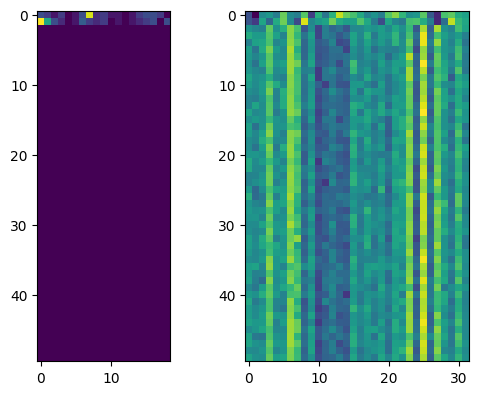

In [17]:
figure = plt.figure(figsize=(12, 10))

ax = figure.add_subplot(2, 2, 1)
ax.imshow(sample[0].categorical[0])

ax = figure.add_subplot(2, 1, 1)
ax.imshow(x_enc.sequences[0].detach())

In [18]:
from src.models.components.base_transformer.encoder_decoder import Encoder
from src.models.components.base_transformer.sub_layers import EncoderLayer
from src.models.components.base_transformer.multihead_attention import MultiHeadAttention
from src.models.components.base_transformer.positionwise_ff import PositionwiseFeedForward

In [20]:
attn = Encoder(
    encoder_layer=EncoderLayer(
        attention=MultiHeadAttention(32, 1),
        feed_forward=PositionwiseFeedForward(32, activation_type="relu")
    ),
    n_layers=1
)

In [21]:
x_att = attn(x_enc)

In [22]:
d(x_att.sequences[0])

tensor([[ 0.7758, -1.9994,  0.1757,  ...,  1.4013, -1.1907, -0.2025],
        [ 0.9439, -0.4874, -0.2644,  ...,  1.4152,  0.8526, -0.5830],
        [-0.0913, -0.0525, -0.8279,  ..., -0.3373,  0.7199,  0.9299],
        ...,
        [ 0.0078, -0.5842,  1.0844,  ..., -0.3644,  1.0874, -0.2336],
        [ 0.1086, -0.3108,  1.0199,  ..., -0.5918,  0.1625, -0.9471],
        [-0.3101, -0.1325, -0.6453,  ..., -0.5450, -0.2703, -0.6323]],
       grad_fn=<SelectBackward0>)

In [23]:
d(x_att.sequences.size())

torch.Size([32, 50, 32])

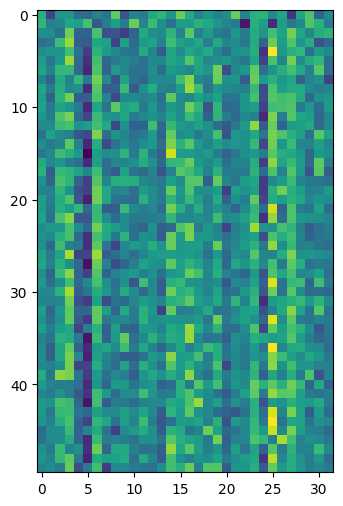

In [24]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
ax.imshow(x_att.sequences[0].detach())

In [25]:
class GRUSeqToSeq(nn.Module):
    def __init__(
            self,
            hidden_size: int, 
            num_layers_gru: int = 1,
            bidirectional: bool = False,
            dropout_gru: float = 0.0
    ) -> None:
        super(GRUSeqToSeq, self).__init__()

        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers_gru,
            bidirectional=bidirectional,
            dropout=dropout_gru
        )

    def forward(self, x: SingleForwardState) -> SingleForwardState:

        lengths = (~x.mask).sum(dim=1)

        packed_sequences = torch.nn.utils.rnn.pack_padded_sequence(
            input=x.sequences, 
            lengths=lengths, 
            batch_first=True, 
            enforce_sorted=False
        )

        state, _ = self.gru(packed_sequences)

        padded_state, _ = torch.nn.utils.rnn.pad_packed_sequence(state, batch_first=True)

        # unpacked_sequences = torch.nn.utils.rnn.unpack_sequence(packed_sequences=packed_sequences)

        return SingleForwardState(
            sequences=padded_state,
            mask=x.mask
        )

In [26]:
x_gru_ = GRUSeqToSeq(
    hidden_size=32,
    num_layers_gru=1
)

In [27]:
x_gru = x_gru_(x_att)

In [28]:
d(x_gru.sequences.size())

torch.Size([32, 19, 32])

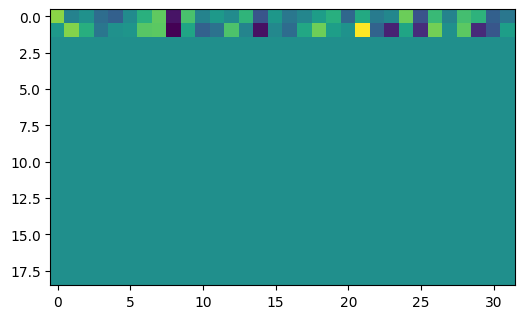

In [29]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
ax.imshow(x_gru.sequences[0].detach())

In [29]:
from src.models.components.pooling.agg_pooling import ConvPooling

In [97]:
class PoolingType(nn.Module):
    num_poolings: int = None

    def __init__(self):
        super(PoolingType, self).__init__()

def first_pooling(hidden_state: torch.Tensor, dim: int = 1):
    assert len(hidden_state.size()) == 3, \
        "hidden state size should be (batch_size x num_seq x seq_len)"

    return hidden_state[:, 0, :] if dim == 1 else hidden_state[:, :, 0]


def last_pooling(hidden_state: torch.Tensor, lengths: torch.Tensor, dim: int = 1):
    assert len(hidden_state.size()) == 3, \
        "hidden state size should be (batch_size x num_seq x seq_len)"
    
    if dim == 1:
        hidden_state = hidden_state[torch.arange(hidden_state.size(0)), lengths - 1, :] # (N, L, B)
    elif dim == 2:
        hidden_state = hidden_state[torch.arange(hidden_state.size(0)), :, lengths - 1] # (N, B, L)
    else:
        raise NotImplementedError("dim is not valid, select dim from the <[1, 2]>")

    return hidden_state


def avg_pooling(hidden_state: torch.Tensor, lengths: torch.Tensor, dim: int = 1):
    assert len(hidden_state.size()) == 3, \
        "hidden state size should be (batch_size x num_seq x seq_len) or (num_seq x seq_len)"

    return torch.mean(hidden_state, dim=dim)


class FirstLastAvgPoolings(PoolingType):
    def __init__(self, dim: int = 1):
        super(FirstLastAvgPoolings, self).__init__()

        self.dim = dim

        self.num_poolings = 3

    def forward(self, hidden_state: torch.Tensor):
        pooled_results = [
            first_pooling(hidden_state, self.dim),
            last_pooling(hidden_state, self.dim),
            avg_pooling(hidden_state, self.dim)
        ]
        hidden_state_pooled = torch.concatenate(pooled_results, dim=self.dim)

        return hidden_state_pooled
    

POOLING_MAPPING = {
    "first_last_avg": FirstLastAvgPoolings
}


class Pooling(nn.Module):
    def __init__(
            self, 
            emb_dim: int,
            pooling_type: str = "all", 
            use_batch_norm: bool = True,
            dim: int = 1
        ) -> None:
        super(Pooling, self).__init__()

        self.dim = dim

        pooling_types = list(POOLING_MAPPING.keys())
        assert pooling_type in pooling_types, \
            f"You should specify pooling type from {pooling_types}, not {pooling_type}"
        
        self.pooling_layer = POOLING_MAPPING[pooling_type](dim=dim)

        input_size = self.pooling_layer.num_poolings * emb_dim

        self.agg_layer = nn.Linear(input_size, emb_dim)

        self.batch_norm = nn.BatchNorm1d(emb_dim) if use_batch_norm else nn.Identity()
        
    def forward(self, hidden_state: SingleForwardState) -> ModelOutput:
        x = self.pooling_layer(hidden_state.sequences)
        x = self.batch_norm(self.agg_layer(x))

        return ModelOutput(
            representations=x,
            logits=None
        )

In [98]:
x_pooled_ = Pooling(emb_dim=32, pooling_type="first_last_avg", use_batch_norm=False, dim=1)

In [99]:
d(x_pooled_)

Pooling(
  (pooling_layer): FirstLastAvgPoolings()
  (agg_layer): Linear(in_features=96, out_features=32, bias=True)
  (batch_norm): Identity()
)

In [100]:
x_pooled = x_pooled_(x_gru)

In [101]:
d(x_pooled.representations.size())

torch.Size([32, 32])

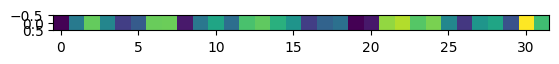

In [102]:
plt.imshow(x_pooled.representations[0].detach().unsqueeze(dim=0))

In [12]:
from src.data.components.collate import ModelOutput
from typing import List, Tuple

In [13]:
ACTIVATION_TYPE_MAPPING = {
    "tanh": nn.Tanh,
    "gelu": nn.GELU,
    "relu": nn.ReLU,
    "none": nn.Identity
}

def init_linear_block_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(layer.bias)

class LinearBlock(nn.Module):
    def __init__(
            self, 
            in_features: int, 
            out_features: int = 1, 
            num_layers: int = 3, 
            dropout_rate: float = 0.0, 
            activation_type: str = "tanh",
            use_batch_norm: bool = False,
            bias: bool = True
        ) -> None:
        super(LinearBlock, self).__init__()

        self.in_features = in_features

        self.dropout = nn.Dropout(p=dropout_rate)

        if activation_type is None:
            self.act = ACTIVATION_TYPE_MAPPING["tanh"]
        elif activation_type in ACTIVATION_TYPE_MAPPING.keys():
            self.act = ACTIVATION_TYPE_MAPPING[activation_type]
        else: 
            NotImplementedError(f"activation_type must be in <{list(ACTIVATION_TYPE_MAPPING.keys())}>")

        if use_batch_norm:
            self.layer_norm = nn.BatchNorm1d
        else:
            self.layer_norm = nn.LayerNorm

        self.linear_block = nn.Sequential(
            *[
                nn.Sequential(
                    *[
                        nn.Linear(in_features // (2 ** i), in_features // (2 ** (i + 1)), bias),
                        self.layer_norm(in_features // (2 ** (i + 1))),
                        self.act()
                    ]
                ) for i in range(num_layers)
            ]
        )
        

        self.out_block = nn.Linear(
            in_features=in_features // (2 ** num_layers), out_features=out_features
        )

        self.cls_layers = nn.Sequential(
            self.dropout,
            self.linear_block,
            self.out_block,
            self.act()
        )

        # weights init
        self.cls_layers.apply(init_linear_block_weights)


    def forward(self, x: ModelOutput) -> ModelOutput:
        logits = self.cls_layers(x.representations)

        return ModelOutput(
            representations=x.representations,
            logits=logits
        )


class MultiTaskLinearBlock(nn.Module):
    def __init__(
            self,
            heads: List[LinearBlock]
    ) -> None: 
        super(MultiTaskLinearBlock, self).__init__()

        self.heads = nn.ModuleList(heads)

    def forward(self, x: ModelOutput) -> ModelOutput:
        multi_state = [
            head(x).logits for head in self.heads
        ]

        logits = torch.concat(multi_state, dim=1) # size(batch_size, num_outputs)
        
        return ModelOutput(
            representations=x.representations,
            logits=logits
        )

In [48]:
x_out = MultiTaskLinearBlock(
    heads=[
        LinearBlock(32, 1, 2)
    ]
)(x_pooled)

In [49]:
d(x_out)

ModelOutput(representations=tensor([[-0.0807, -0.0925,  0.0185,  ...,  0.0862,  0.0276, -0.0489],
        [-0.0164, -0.0240,  0.0047,  ...,  0.0191,  0.0072, -0.0139],
        [-0.0550, -0.0686,  0.0153,  ...,  0.0614,  0.0193, -0.0378],
        ...,
        [-0.0029, -0.0036,  0.0004,  ...,  0.0021,  0.0021, -0.0017],
        [-0.1101, -0.1254,  0.0267,  ...,  0.1202,  0.0347, -0.0692],
        [-0.0092, -0.0124, -0.0006,  ...,  0.0077,  0.0030, -0.0051]],
       grad_fn=<SqueezeBackward1>), logits=tensor([[-0.3835],
        [-0.4595],
        [-0.3846],
        [-0.5128],
        [-0.4077],
        [-0.4268],
        [-0.4213],
        [-0.6295],
        [-0.4995],
        [-0.0691],
        [-0.4164],
        [-0.4121],
        [-0.3576],
        [-0.3559],
        [-0.3748],
        [-0.3683],
        [-0.3324],
        [-0.3280],
        [-0.3166],
        [-0.3467],
        [-0.4153],
        [-0.5702],
        [-0.4393],
        [-0.3760],
        [-0.3955],
        [-0.4136],
 

In [14]:
import time
import pandas as pd

In [15]:
import bitsandbytes as bnb

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


In [16]:
from src.utils.metrics import GINI

In [17]:
class Trainer:
    def __init__(
            self, 
            model: nn.Module, 
            optimizer: torch.optim.Optimizer, 
            criterion: nn.BCEWithLogitsLoss,
            train_dataloader: torch.utils.data.DataLoader, 
            scheduler: torch.optim.lr_scheduler.LRScheduler = None
        ) -> None:

        self.model = model
    
        self.criterion = criterion
        
        self.task_names = ["tanh_output"]
        self.task_weights = torch.tensor([1.0])

        self.train_data = train_dataloader

        self.optimizer = optimizer
        self.scheduler = scheduler

        self.gini = GINI()

        self.train_results = list()

    def multioutput_loss(self, logits: ModelOutput, targets: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # logits size is (batch_size, num_outputs)
        # targets size is (batch_size, 1)

        targets = targets.expand(size=(-1, len(self.task_names))) # to size like logits

        weighted_loss = self.task_weights * self.criterion(logits, targets)
        
        # (self.task_weights * self.criterion(logits, targets)).sum() / len(self.task_names)
        loss = weighted_loss.sum() / (len(weighted_loss) * len(self.task_names))
        branched_loss = (weighted_loss.sum(dim=0) / len(weighted_loss)).detach()

        return loss, branched_loss

    def fit(self, epochs: int = 3, show_step: int = 100):
        n_total_steps = len(self.train_data)

        loss_step = 0
        gini_step = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()

            self.epoch = epoch
            
            print('Epoch %s/%s' % (epoch + 1, epochs))

            for step, batch in enumerate(self.train_data):
                self.optimizer.zero_grad(set_to_none=True)

                x = ModelInput(
                    numerical=batch.numerical,
                    categorical=batch.categorical,
                    lengths=batch.lengths
                )

                labels = batch.targets

                outputs = self.model(x)
        
                loss, _ = self.multioutput_loss(
                    logits=outputs.logits,
                    targets=labels
                )

                loss.backward()
                self.optimizer.step()

                loss_step += loss.item()
                gini_step += self.gini(outputs.logits[:, 0], labels.squeeze())

                self.train_results.append(
                    [
                        self.epoch * n_total_steps + step, 
                        loss.item()

                    ]
                )

                if (step + 1) % show_step == 0:
                    print(
                        f"Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s | Loss: {loss_step / show_step:.4f} | GINI: {gini_step / show_step:.1f}"
                    )
                    gini_step = 0
                    loss_step = 0

        self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss"])

        print('\nDone.')


    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [18]:
model = nn.Sequential(
    EncoderLayer(
        numerical_features=features_dict["numerical"],
        categorical_features=features_dict["categorical"],
        embedding_dim=32,
        dropout_inputs=0.1
    ),
    SimpleAttention1d(
        features_dim=32
    ),
    GRUSeqToSeq(
        hidden_size=32,
        num_layers_gru=1
    ),
    ConvPooling(
        pooling_type="avg", dim=1
    ),
    MultiTaskLinearBlock(
        heads=[
            LinearBlock(32, 1, 2)
        ]
    )
)

In [19]:
opt = bnb.optim.Adam8bit(model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

train_model = Trainer(
    model=model, 
    criterion=nn.BCEWithLogitsLoss(
        reduction="none"
    ),
    train_dataloader=dataloader, 
    optimizer=opt
)

In [ ]:
train_model.fit(epochs=3, show_step=30)

In [109]:
test_sample = next(iter(test_dataloader))

In [168]:
preds = model(test_sample).logits

In [169]:
d(GINI()(preds, test_sample.targets))

tensor(44.4487)

In [ ]:
# 1 - 40.82 ~ lr 1e-4
# 2 - 44.80 ~ lr 1e-2

In [118]:
sorted_preds = torch.concatenate((torch.sigmoid(preds), test_sample.targets), dim=1).sort(dim=0).values.detach()

In [123]:
from sklearn.metrics import roc_curve

In [126]:
fpr, tpr, _ = roc_curve(test_sample.targets, torch.sigmoid(preds).detach())

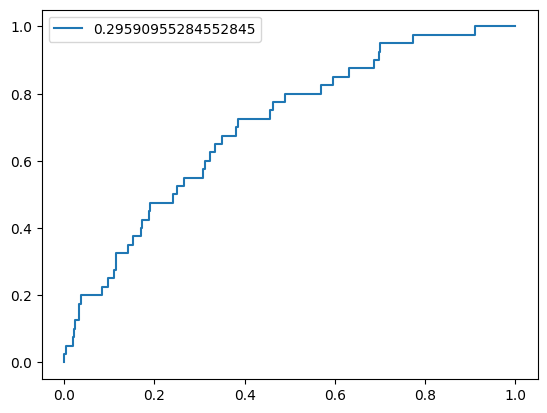

In [131]:
plt.plot(fpr, tpr, label=np.trapz(fpr, tpr))
plt.legend(loc=2)
plt.show()

# Pretrained model

In [3]:
import torch
from torch import nn

In [1]:
from src.models.ch_lit_module import CHLitModule
from IPython.display import display as d

In [4]:
class PretrainedModel(nn.Module):
    def __init__(self, ckpt_path: str):
        super().__init__()
        
        self.net = CHLitModule.load_from_checkpoint(ckpt_path)
        self.net.eval()
        self.net.freeze()

    def forward(self, inputs):
        return self.net(inputs)

In [5]:
trained_model = PretrainedModel("logs/train/runs/2024-05-17_15-29-11/checkpoints/epoch_008.ckpt")

/home/danil/projects/LHT_credits_history/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [6]:
d(dict(trained_model.net.named_parameters()))

{'net.layers.0.embeddings.embeddings.0.weight': Parameter containing:
 tensor([[ 0.3699, -0.2070, -0.0574,  0.2860,  0.2871, -0.6516, -0.6582,  0.5127],
         [ 0.1410,  0.2636, -0.3663,  0.0577, -0.0728, -0.2222, -0.1203,  0.2031],
         [-0.0567,  0.1484, -0.0080,  0.4410, -0.4481,  0.6227,  0.2812,  0.1424],
         [ 0.5029,  0.5404,  0.2679, -0.2057,  0.1066,  0.6148,  0.0578,  0.2919],
         [ 0.0854, -0.5548, -0.3337, -0.7263, -0.8032,  0.1141,  0.6581, -0.1204],
         [ 0.0527,  0.1385,  0.4128,  0.0555, -0.0998,  0.6886,  0.2679,  0.2707],
         [ 0.0658, -0.6800,  0.2542,  0.0125,  0.1882, -0.2867, -0.4131, -0.0066],
         [-0.5129,  0.3926, -0.1316,  0.1095,  0.1492,  0.0342, -0.1043, -0.1082],
         [ 0.7351, -0.2886, -0.0506, -0.1919, -0.3095, -0.0912, -0.4972, -0.6453],
         [-0.0855,  0.7006,  0.1623,  0.0464, -0.3214,  0.2569,  0.4515, -0.2935],
         [ 0.1043, -1.0722,  0.4554, -0.1094, -0.4576,  0.2693, -0.4176, -0.5339],
         [-0.0371

In [7]:
d(trained_model.net)

CHLitModule(
  (net): SequentialLitModel(
    (layers): Sequential(
      (0): EncoderLayer(
        (dropout): Dropout(p=0.3, inplace=False)
        (embeddings): EmbeddingLayer(
          (embeddings): ModuleList(
            (0-1): 2 x Embedding(20, 8)
            (2): Embedding(7, 8)
            (3): Embedding(6, 8)
            (4): Embedding(1, 8)
            (5): Embedding(4, 8)
            (6): Embedding(14, 8)
            (7-9): 3 x Embedding(20, 8)
            (10-12): 3 x Embedding(2, 8)
            (13-14): 2 x Embedding(7, 8)
            (15): Embedding(6, 8)
            (16): Embedding(5, 8)
            (17): Embedding(18, 8)
            (18): Embedding(17, 8)
          )
        )
        (out_linear_block): Linear(in_features=158, out_features=32, bias=True)
        (num_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): PositionwiseFeedForward(
        (position_wise_layer): Sequential(
          (0): Linear(in_feature

In [16]:
from src.utils.metrics import GINI

In [20]:
d(test_sample)

ModelBatch(numerical=tensor([[[ 1.9200,  1.0005,  0.8417,  0.5399,  7.2181,  0.0000],
         [ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
         [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6800,  0.8012,  0.7182,  0.6959,  7.2181,  0.0000],
         [ 1.9200,  1.0005,  0.8417,  0.5399,  7.2181,  0.0000],
         [ 2.5200,  1.6636,  0.9957, -0.0927,  7.2181,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.0400,  1.1128,  0.8969,  0.4422,  7.2181,  0.0000],
         [ 2.2800,  1.3662,  0.9791,  0.2032,  7.2181,  0.0000],
         [ 2.8800,  2.2093,  0.8030, 

In [24]:
test_sample = next(iter(test_dataloader))
d(GINI()(trained_model.net(test_sample).logits[:, 0], test_sample.targets))
d(GINI()(trained_model.net(test_sample).logits[:, 1], test_sample.targets))

tensor(54.0041)

tensor(55.8003)

In [171]:
preds = [
    trained_model.net(sample).logits.ravel() for i, sample in enumerate(test_dataloader) if i < 5
]

In [172]:
preds = torch.concatenate(preds)

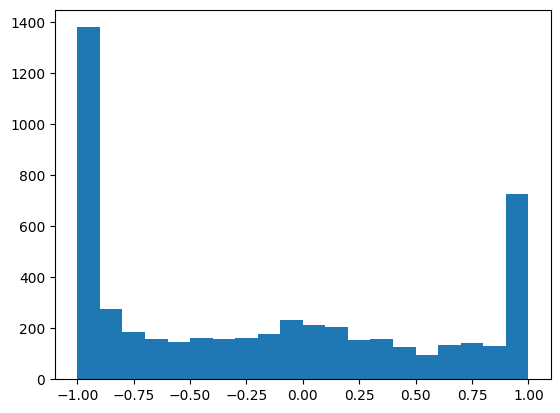

In [173]:
plt.show(plt.hist(preds, bins=20))

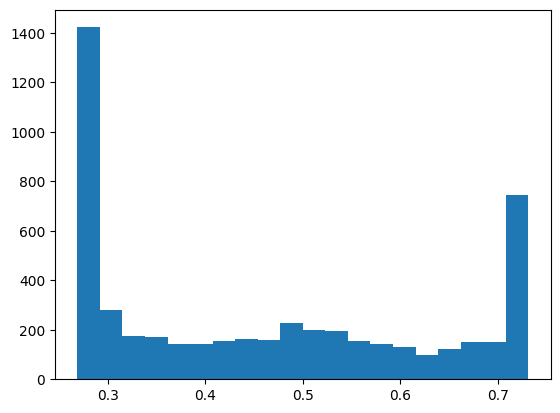

In [174]:
plt.show(plt.hist(torch.sigmoid(preds), bins=20))

In [19]:
import thunder

In [26]:
jit_trained_model = thunder.jit(trained_model.net.net)

In [27]:
preds = jit_trained_model(sample[0])

InterpreterError: Encountered exception AttributeError: module 'dis' has no attribute '_parse_exception_table' while tracing SequentialLitModel(
  (layers): Sequential(
    (0): EncoderLayer(
      (dropout): Dropout(p=0.3, inplace=False)
      (embeddings): EmbeddingLayer(
        (embeddings): ModuleList(
          (0-1): 2 x Embedding(18, 32)
          (2-3): 2 x Embedding(17, 32)
          (4): Embedding(16, 32)
          (5): Embedding(20, 32)
          (6): Embedding(7, 32)
          (7): Embedding(6, 32)
          (8): Embedding(4, 32)
          (9): Embedding(14, 32)
          (10): Embedding(4, 32)
          (11-12): 2 x Embedding(7, 32)
          (13): Embedding(6, 32)
          (14): Embedding(4, 32)
          (15-16): 2 x Embedding(2, 32)
          (17): Embedding(4, 32)
          (18): Embedding(25, 32)
          (19): Embedding(5, 32)
          (20): Embedding(26, 32)
          (21): Embedding(5, 32)
          (22): Embedding(27, 32)
          (23): Embedding(7, 32)
          (24): Embedding(19, 32)
          (25): Embedding(9, 32)
          (26): Embedding(5, 32)
          (27): Embedding(15, 32)
          (28-30): 3 x Embedding(20, 32)
        )
      )
      (out_linear_block): Linear(in_features=992, out_features=32, bias=True)
    )
    (1): GRUSeqToSeq(
      (gru): GRU(32, 32, batch_first=True)
    )
    (2): ConvPooling(
      (pooling_layer): AllPoolings()
      (conv_layer): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    )
    (3): MultiOutputLinearBlock(
      (heads): ModuleList(
        (0): LinearBlock(
          (dropout): Dropout(p=0.0, inplace=False)
          (linear_block): Sequential(
            (0): Sequential(
              (0): Linear(in_features=32, out_features=16, bias=True)
              (1): GELU(approximate='none')
              (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            )
            (1): Sequential(
              (0): Linear(in_features=16, out_features=8, bias=True)
              (1): GELU(approximate='none')
              (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            )
          )
          (out_block): Linear(in_features=8, out_features=1, bias=True)
          (cls_layers): Sequential(
            (0): Dropout(p=0.0, inplace=False)
            (1): Sequential(
              (0): Sequential(
                (0): Linear(in_features=32, out_features=16, bias=True)
                (1): GELU(approximate='none')
                (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
              )
              (1): Sequential(
                (0): Linear(in_features=16, out_features=8, bias=True)
                (1): GELU(approximate='none')
                (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
              )
            )
            (2): Linear(in_features=8, out_features=1, bias=True)
            (3): GELU(approximate='none')
          )
        )
      )
    )
  )
):


In [28]:
trained_model.net.to_onnx("credits_history_lit_model.onnx", sample[0], export_params=True)

RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: ModelInput